# Probabilistic Bayesian Neural Networks
https://keras.io/examples/keras_recipes/bayesian_neural_networks/

## Setup

### Ambiente
Creamos un ambiente con la paquetería necesaria

``conda create -n env_tf_bayes``

``conda activate env_tf_bayes``

``pip install tensorflow-probability``

``pip install tensorflow-datasets``

### Bibliotecas

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Create training and evaluation datasets

In [6]:
def get_train_and_test_splits(train_size, batch_size=1):
    # Importar datos
    data = pd.read_csv("./../data/train.csv")

    # Select the required columns
    cols = [
        'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 
        'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
        'EstimatedSalary', 'Exited'
    ]
    data = data[cols].copy()
    # One-hot encode the 'Geography' column
    data = pd.get_dummies(data, columns=['Geography'], prefix='Geo')

    # Convert 'Gender' to boolean. 
    # Here we assume 'Male' maps to True and 'Female' to False.
    data['Gender'] = data['Gender'].apply(lambda x: True if x == 'Male' else False)

    # Convert other binary columns to boolean
    bool_cols = ['HasCrCard', 'IsActiveMember', 'Exited']
    data[bool_cols] = data[bool_cols].astype(bool)

    # Ensure 'Age' is integer type
    data['Age'] = data['Age'].astype(int)

    # Scale 'Balance' and 'EstimatedSalary' using MinMaxScaler
    scaler = MinMaxScaler()
    data[['Balance', 'EstimatedSalary']] = scaler.fit_transform(data[['Balance', 'EstimatedSalary']])
    
    # VARIABLE OBJETIVO Y VARIABLES INDEPENDIENTES
    features = data.drop(columns=["Exited"])
    labels = data["Exited"]

    # Convertir a tensores de TensorFlow
    features_dict = {col: tf.convert_to_tensor(features[col].values, dtype=tf.float32) for col in features.columns}
    labels_tensor = tf.convert_to_tensor(labels.values, dtype=tf.float32)

    # Crear dataset de TensorFlow
    dataset = tf.data.Dataset.from_tensor_slices((features_dict, labels_tensor))
    dataset = dataset.cache().shuffle(len(data)).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Definir train_size y test_size correctamente
    test_size = len(data) - train_size  # Corregir tamaño del dataset de prueba

    train_dataset = dataset.take(train_size).batch(batch_size)
    test_dataset = dataset.skip(train_size).take(test_size).batch(batch_size)  # Agregar `take(test_size)`

    return train_dataset, test_dataset

## Compile, train, and evaluate the model

In [35]:
hidden_units = [8, 8]
learning_rate = 0.001


def run_experiment(model, loss, train_dataset, test_dataset, class_weight=None):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=loss,
        metrics=['accuracy', tf.keras.metrics.Recall()]
    )

    print("Start training the model...")
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=test_dataset,
        verbose=1,
        class_weight=class_weight
    )
    print("Model training finished.")

    print("Evaluating model performance...")
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset, verbose=1)
    print('Test Accuracy: {:.2f}%'.format(test_accuracy * 100))
    print('Test Recall: {:.2f}%'.format(test_recall * 100))

    return history


## Create model inputs

In [8]:
FEATURE_NAMES = [
    'CreditScore', 
    'Gender', 
    'Age', 
    'Tenure', 
    'Balance', 
    'NumOfProducts', 
    'HasCrCard', 
    'IsActiveMember', 
    'EstimatedSalary', 
    'Geo_France', 
    'Geo_Germany', 
    'Geo_Spain'
]


def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs



## Experiment 1: standard neural network
We create a standard deterministic neural network model as a baseline.

In [9]:
def create_baseline_model():
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    x = keras.layers.concatenate(input_values)
    x = layers.BatchNormalization()(x)

    # Equivalent layers to the Sequential model
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer with sigmoid for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


Let's split the wine dataset into training and test sets, with 85% and 15% of the examples, respectively.

In [10]:
# Read the full data to compute class weights
data = pd.read_csv("./../data/train.csv")
pos = np.sum(data['Exited'] == 1)
neg = np.sum(data['Exited'] == 0)
total = pos + neg

# Compute class weights
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.63
Weight for class 1: 2.36


In [11]:
# data = pd.read_csv("./../data/train.csv")
dataset_size = data.shape[0]
batch_size = 256
train_size = int(dataset_size * 0.85)
train_dataset, test_dataset = get_train_and_test_splits(train_size, batch_size)

2025-04-16 18:16:28.084778: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Now let's train the baseline model. We use the MeanSquaredError as the loss function.

In [13]:
num_epochs = 100
bce_loss = keras.losses.BinaryCrossentropy()
# baseline_model = create_baseline_model()

baseline_model = create_baseline_model()
history = run_experiment(
    baseline_model,
    bce_loss,
    train_dataset,
    test_dataset,
    class_weight=class_weight
)


# run_experiment(baseline_model, bce_loss, train_dataset, test_dataset)

Start training the model...
Epoch 1/100


2025-04-16 18:35:52.867393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [165034]
	 [[{{node Placeholder/_10}}]]
2025-04-16 18:35:52.867838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype float and shape [165034]
	 [[{{node Placeholder/_12}}]]


548/548 [==============================] - 11s 17ms/step - loss: 0.7122 - accuracy: 0.4942 - recall_2: 0.6075 - val_loss: 0.6480 - val_accuracy: 0.7516 - val_recall_2: 0.6950
Epoch 2/100
548/548 [==============================] - 8s 14ms/step - loss: 0.6461 - accuracy: 0.6034 - recall_2: 0.6575 - val_loss: 0.5681 - val_accuracy: 0.7673 - val_recall_2: 0.7345
Epoch 3/100
548/548 [==============================] - 9s 16ms/step - loss: 0.6002 - accuracy: 0.6909 - recall_2: 0.6872 - val_loss: 0.5223 - val_accuracy: 0.7826 - val_recall_2: 0.7223
Epoch 4/100
548/548 [==============================] - 8s 14ms/step - loss: 0.5777 - accuracy: 0.7325 - recall_2: 0.6940 - val_loss: 0.5063 - val_accuracy: 0.7885 - val_recall_2: 0.7213
Epoch 5/100
548/548 [==============================] - 9s 17ms/step - loss: 0.5631 - accuracy: 0.7515 - recall_2: 0.7027 - val_loss: 0.5017 - val_accuracy: 0.7925 - val_recall_2: 0.7328
Epoch 6/100
548/548 [==============================] - 8s 14ms/step - loss: 0.547

We take a sample from the test set use the model to obtain predictions for them. Note that since the baseline model is deterministic, we get a single a point estimate prediction for each test example, with no information about the uncertainty of the model nor the prediction.

In [14]:
sample = 10
examples, targets = list(test_dataset.unbatch().shuffle(batch_size * 10).batch(sample))[
    0
]

predicted = baseline_model(examples).numpy()
for idx in range(sample):
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {targets[idx]}")

2025-04-16 18:50:57.061128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype float and shape [165034]
	 [[{{node Placeholder/_9}}]]
2025-04-16 18:50:57.065143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [165034]
	 [[{{node Placeholder/_1}}]]


Predicted: 0.2 - Actual: 0.0
Predicted: 0.7 - Actual: 1.0
Predicted: 1.0 - Actual: 1.0
Predicted: 0.9 - Actual: 1.0
Predicted: 0.2 - Actual: 0.0
Predicted: 0.8 - Actual: 0.0
Predicted: 0.4 - Actual: 0.0
Predicted: 0.2 - Actual: 0.0
Predicted: 0.0 - Actual: 0.0
Predicted: 1.0 - Actual: 1.0


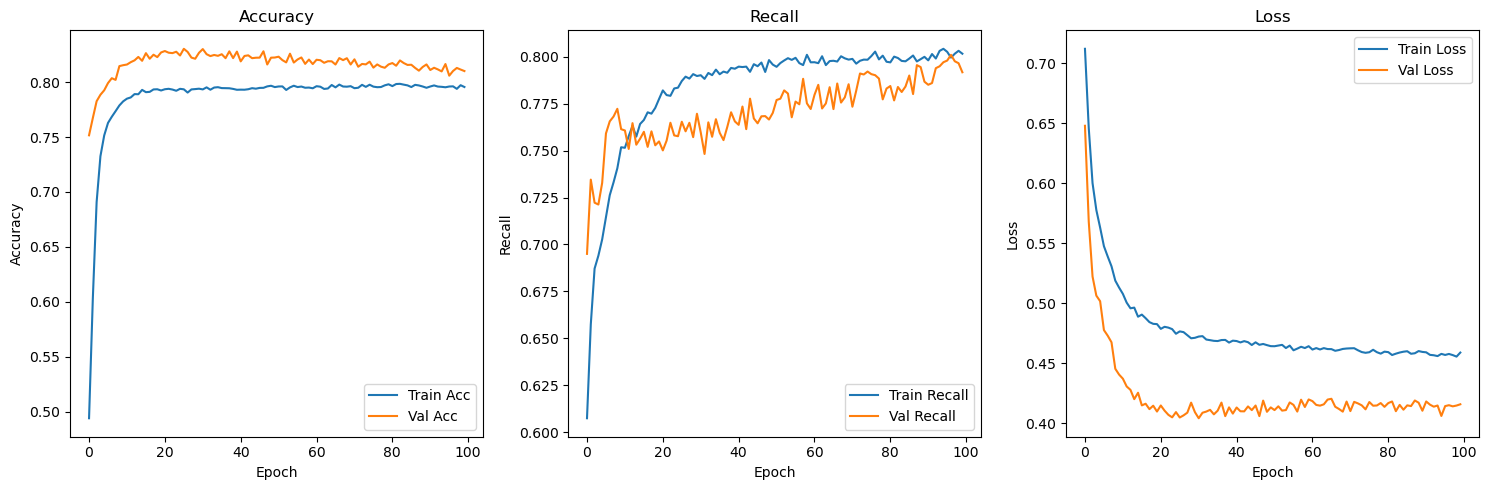

In [20]:
def plot_metrics(history):
    recall_key = next((k for k in history.history.keys() if 'recall' in k and not k.startswith('val_')), None)
    val_recall_key = next((k for k in history.history.keys() if 'val_recall' in k), None)

    plt.figure(figsize=(15, 5))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Recall
    if recall_key and val_recall_key:
        plt.subplot(1, 3, 2)
        plt.plot(history.history[recall_key], label='Train Recall')
        plt.plot(history.history[val_recall_key], label='Val Recall')
        plt.title('Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()

    # Loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history)

## Experiment 2: Bayesian neural network (BNN)

The object of the Bayesian approach for modeling neural networks is to capture the epistemic uncertainty, which is uncertainty about the model fitness, due to limited training data.

The idea is that, instead of learning specific weight (and bias) values in the neural network, the Bayesian approach learns weight distributions - from which we can sample to produce an output for a given input - to encode weight uncertainty.

Thus, we need to define prior and the posterior distributions of these weights, and the training process is to learn the parameters of these distributions.

In [22]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


We use the tfp.layers.DenseVariational layer instead of the standard keras.layers.Dense layer in the neural network model.

In [23]:

def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1, activation="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


The epistemic uncertainty can be reduced as we increase the size of the training data. That is, the more data the BNN model sees, the more it is certain about its estimates for the weights (distribution parameters). Let's test this behaviour by training the BNN model on a small subset of the training set, and then on the full training set, to compare the output variances.

### Train BNN with a small training subset.

In [24]:
num_epochs = 500
train_sample_size = int(train_size * 0.3)
small_train_dataset = train_dataset.unbatch().take(train_sample_size).batch(batch_size)

bnn_model_small = create_bnn_model(train_sample_size)
history = run_experiment(
    bnn_model_small, 
    bce_loss, 
    small_train_dataset, 
    test_dataset,
    class_weight=class_weight
)


# bnn_model_small = create_bnn_model(train_sample_size)
# run_experiment(bnn_model_small, bce_loss, small_train_dataset, test_dataset)

Start training the model...
Epoch 1/100


2025-04-16 18:59:51.391197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype float and shape [165034]
	 [[{{node Placeholder/_6}}]]
2025-04-16 18:59:51.391668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [165034]
	 [[{{node Placeholder/_10}}]]


165/165 [==============================] - 5s 18ms/step - loss: 0.7776 - accuracy: 0.7748 - recall_3: 0.0202 - val_loss: 0.5763 - val_accuracy: 0.7423 - val_recall_3: 0.0832
Epoch 2/100
165/165 [==============================] - 4s 24ms/step - loss: 0.7634 - accuracy: 0.7642 - recall_3: 0.0404 - val_loss: 0.5894 - val_accuracy: 0.7515 - val_recall_3: 0.0515
Epoch 3/100
165/165 [==============================] - 3s 16ms/step - loss: 0.7399 - accuracy: 0.7329 - recall_3: 0.0917 - val_loss: 0.5916 - val_accuracy: 0.7466 - val_recall_3: 0.0682
Epoch 4/100
165/165 [==============================] - 3s 17ms/step - loss: 0.7312 - accuracy: 0.7278 - recall_3: 0.1100 - val_loss: 0.6120 - val_accuracy: 0.7248 - val_recall_3: 0.1123
Epoch 5/100
165/165 [==============================] - 3s 17ms/step - loss: 0.7260 - accuracy: 0.7057 - recall_3: 0.1451 - val_loss: 0.6294 - val_accuracy: 0.6707 - val_recall_3: 0.1921
Epoch 6/100
165/165 [==============================] - 4s 25ms/step - loss: 0.7187

Since we have trained a BNN model, the model produces a different output each time we call it with the same input, since each time a new set of weights are sampled from the distributions to construct the network and produce an output. The less certain the mode weights are, the more variability (wider range) we will see in the outputs of the same inputs.

In [25]:

def compute_predictions(model, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    for idx in range(sample):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )


compute_predictions(bnn_model_small)

Predictions mean: 0.26, min: 0.16, max: 0.48, range: 0.32 - Actual: 0.0
Predictions mean: 0.59, min: 0.35, max: 0.75, range: 0.39 - Actual: 1.0
Predictions mean: 0.71, min: 0.45, max: 0.81, range: 0.35 - Actual: 1.0
Predictions mean: 0.63, min: 0.35, max: 0.77, range: 0.42 - Actual: 1.0
Predictions mean: 0.42, min: 0.19, max: 0.7, range: 0.51 - Actual: 0.0
Predictions mean: 0.61, min: 0.35, max: 0.76, range: 0.41 - Actual: 0.0
Predictions mean: 0.39, min: 0.2, max: 0.63, range: 0.43 - Actual: 0.0
Predictions mean: 0.48, min: 0.2, max: 0.71, range: 0.51 - Actual: 0.0
Predictions mean: 0.2, min: 0.12, max: 0.29, range: 0.17 - Actual: 0.0
Predictions mean: 0.59, min: 0.27, max: 0.76, range: 0.49 - Actual: 1.0


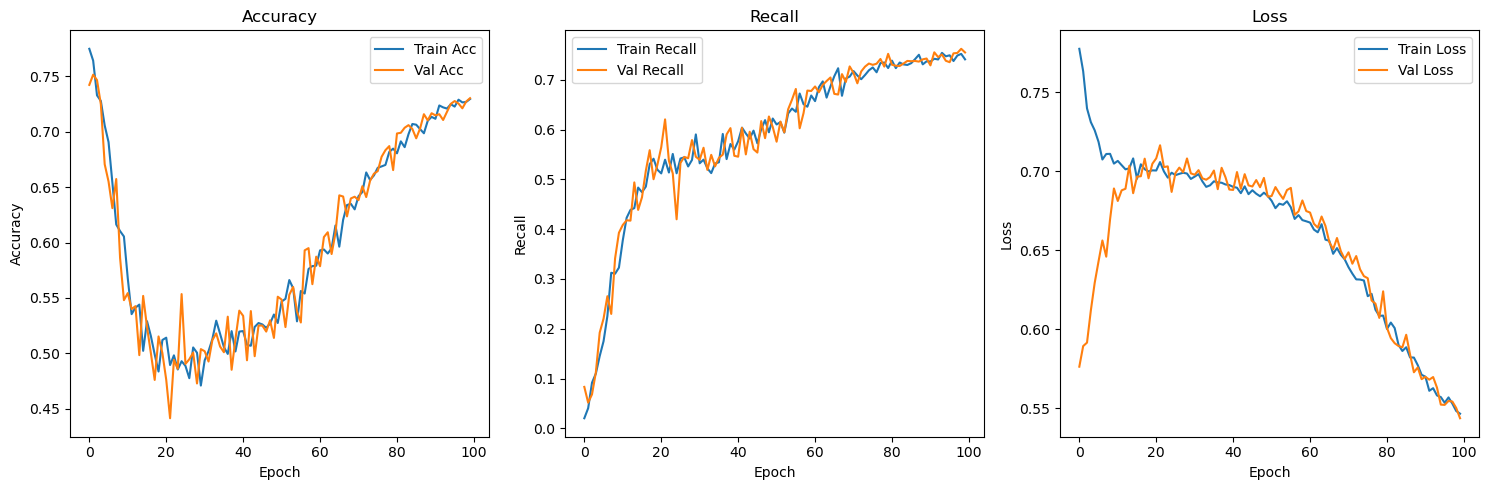

In [26]:
plot_metrics(history)

### Train BNN with the whole training set.

In [27]:
num_epochs = 500

bnn_model_full = create_bnn_model(train_size)
history = run_experiment(
    bnn_model_full, 
    bce_loss, 
    train_dataset, 
    test_dataset,
    class_weight=class_weight
)

# bnn_model_full = create_bnn_model(train_size)
# run_experiment(bnn_model_full, mse_loss, train_dataset, test_dataset)

compute_predictions(bnn_model_full)

Start training the model...
Epoch 1/100


2025-04-16 19:06:44.261264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [165034]
	 [[{{node Placeholder/_3}}]]
2025-04-16 19:06:44.261732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype float and shape [165034]
	 [[{{node Placeholder/_4}}]]


548/548 [==============================] - 7s 9ms/step - loss: 0.7328 - accuracy: 0.7716 - recall_4: 0.0260 - val_loss: 0.6136 - val_accuracy: 0.7485 - val_recall_4: 0.0639
Epoch 2/100
548/548 [==============================] - 5s 9ms/step - loss: 0.7079 - accuracy: 0.6899 - recall_4: 0.1770 - val_loss: 0.6614 - val_accuracy: 0.6269 - val_recall_4: 0.2786
Epoch 3/100
548/548 [==============================] - 5s 8ms/step - loss: 0.7016 - accuracy: 0.6027 - recall_4: 0.3294 - val_loss: 0.6801 - val_accuracy: 0.5566 - val_recall_4: 0.3808
Epoch 4/100
548/548 [==============================] - 5s 8ms/step - loss: 0.6988 - accuracy: 0.5543 - recall_4: 0.4172 - val_loss: 0.7012 - val_accuracy: 0.4826 - val_recall_4: 0.5383
Epoch 5/100
548/548 [==============================] - 5s 8ms/step - loss: 0.6986 - accuracy: 0.5058 - recall_4: 0.5004 - val_loss: 0.6949 - val_accuracy: 0.5047 - val_recall_4: 0.4947
Epoch 6/100
548/548 [==============================] - 5s 8ms/step - loss: 0.6973 - acc

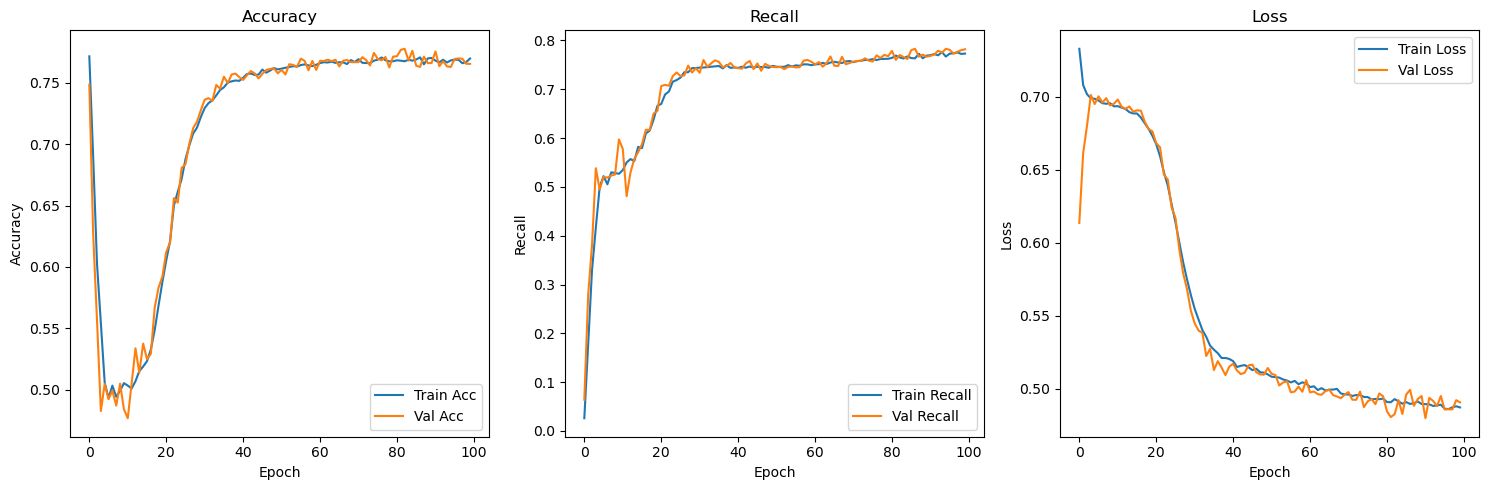

In [28]:
plot_metrics(history)

## Experiment 3: probabilistic Bayesian neural network
So far, the output of the standard and the Bayesian NN models that we built is deterministic, that is, produces a point estimate as a prediction for a given example. We can create a probabilistic NN by letting the model output a distribution. In this case, the model captures the aleatoric uncertainty as well, which is due to irreducible noise in the data, or to the stochastic nature of the process generating the data.

In this example, we model the output as a IndependentNormal distribution, with learnable mean and variance parameters. If the task was classification, we would have used IndependentBernoulli with binary classes, and OneHotCategorical with multiple classes, to model distribution of the model output.

In [30]:

def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    ##############################
    #Since we're modeling a binary target, the probabilistic output should be a Bernoulli distribution, not a Normal one.
    logits = layers.Dense(units=1)(features)
    outputs = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(logits=t))(logits)


    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


Since the output of the model is a distribution, rather than a point estimate, we use the negative loglikelihood as our loss function to compute how likely to see the true data (targets) from the estimated distribution produced by the model.

In [36]:
#Keep our negative_loglikelihood() function but use it with the Bernoulli distribution
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(tf.cast(targets, tf.float32))


num_epochs = 1000

prob_bnn_model = create_probablistic_bnn_model(train_size)
history = run_experiment(
    prob_bnn_model, 
    negative_loglikelihood,
    train_dataset, 
    test_dataset,
    class_weight=class_weight
)



# prob_bnn_model = create_probablistic_bnn_model(train_size)
# run_experiment(prob_bnn_model, negative_loglikelihood, train_dataset, test_dataset)

Start training the model...
Epoch 1/1000


2025-04-16 19:30:08.503340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [165034]
	 [[{{node Placeholder/_0}}]]
2025-04-16 19:30:08.503785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [165034]
	 [[{{node Placeholder/_3}}]]


548/548 [==============================] - 6s 9ms/step - loss: 0.3845 - accuracy: 0.5504 - recall_6: 0.4161 - val_loss: 0.6635 - val_accuracy: 0.5260 - val_recall_6: 0.4566
Epoch 2/1000
548/548 [==============================] - 5s 8ms/step - loss: 0.3022 - accuracy: 0.5018 - recall_6: 0.4987 - val_loss: 0.7646 - val_accuracy: 0.4726 - val_recall_6: 0.5380
Epoch 3/1000
548/548 [==============================] - 5s 9ms/step - loss: 0.2305 - accuracy: 0.4499 - recall_6: 0.5828 - val_loss: 0.8854 - val_accuracy: 0.4283 - val_recall_6: 0.6264
Epoch 4/1000
548/548 [==============================] - 6s 11ms/step - loss: 0.1822 - accuracy: 0.4088 - recall_6: 0.6537 - val_loss: 1.0164 - val_accuracy: 0.3875 - val_recall_6: 0.6781
Epoch 5/1000
548/548 [==============================] - 4s 7ms/step - loss: 0.1452 - accuracy: 0.3799 - recall_6: 0.7148 - val_loss: 1.1779 - val_accuracy: 0.3578 - val_recall_6: 0.7460
Epoch 6/1000
548/548 [==============================] - 5s 8ms/step - loss: 0.1087

Now let's produce an output from the model given the test examples. The output is now a distribution, and we can use its mean and variance to compute the confidence intervals (CI) of the prediction.

In [37]:
#To get probabilities from the Bernoulli distribution:
prediction_distribution = prob_bnn_model(examples)
prediction_mean = prediction_distribution.mean().numpy().flatten().tolist()

# You won’t have .stddev() or .mean ± 1.96 * stddev like in the Normal case. Instead, you can:
# sample multiple times from the distribution
# report percentiles (like 5%–95%) to express uncertainty



for idx in range(sample):
    prob = prediction_mean[idx]
    print(f"Predicted probability: {round(prob, 2)} - Actual: {targets[idx]}")


Predicted probability: 1.0 - Actual: 0.0
Predicted probability: 1.0 - Actual: 1.0
Predicted probability: 1.0 - Actual: 1.0
Predicted probability: 1.0 - Actual: 1.0
Predicted probability: 1.0 - Actual: 0.0
Predicted probability: 1.0 - Actual: 0.0
Predicted probability: 1.0 - Actual: 0.0
Predicted probability: 1.0 - Actual: 0.0
Predicted probability: 1.0 - Actual: 0.0
Predicted probability: 1.0 - Actual: 1.0


In [38]:
# Sample multiple times from the Bernoulli distributions
samples = []
num_samples = 100

for _ in range(num_samples):
    samples.append(prob_bnn_model(examples).sample().numpy().flatten())

# Shape: (num_samples, batch_size)
samples_array = np.array(samples)

# Compute percentiles
p5 = np.percentile(samples_array, 5, axis=0)
p95 = np.percentile(samples_array, 95, axis=0)
mean_probs = prediction_distribution.mean().numpy().flatten()

for idx in range(sample):
    print(
        f"Mean: {round(mean_probs[idx], 2)} - "
        f"5th percentile: {round(p5[idx], 2)} - "
        f"95th percentile: {round(p95[idx], 2)} - "
        f"Actual: {targets[idx]}"
    )


Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 0.0
Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 1.0
Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 1.0
Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 1.0
Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 0.0
Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 0.0
Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 0.0
Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 0.0
Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 0.0
Mean: 1.0 - 5th percentile: 1.0 - 95th percentile: 1.0 - Actual: 1.0


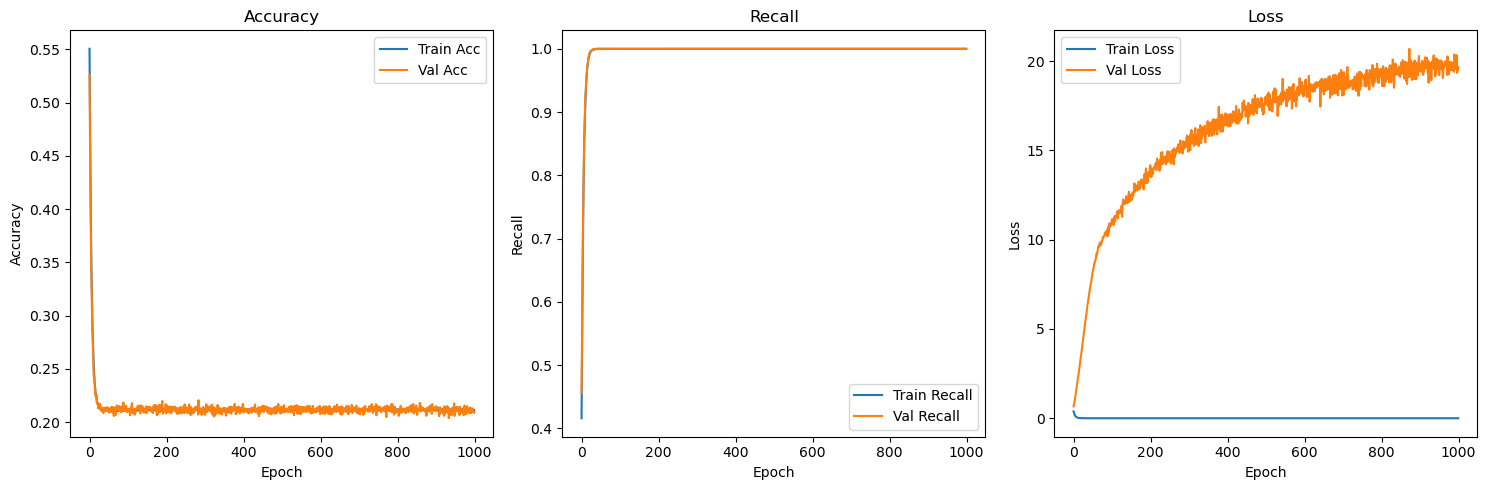

In [39]:
plot_metrics(history)